In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models, callbacks

# Load CSVs
df_1and2 = pd.read_csv('burns_1and2.csv')
df_3 = pd.read_csv('burns_3rd.csv')

# Assign labels: 0 = 1st/2nd degree (urgent care), 1 = 3rd degree (ER)
df_1and2['binary_label'] = 0
df_3['binary_label'] = 1

# Combine
df_all = pd.concat([df_1and2, df_3], ignore_index=True)
print(df_all['binary_label'].value_counts())
print(df_all.sample(5))


binary_label
0    4876
1    1023
Name: count, dtype: int64
                                               filepath           label  \
65    C:\Users\dabne\.cache\kagglehub\datasets\fares...  1_and_2_degree   
5724  C:\Users\dabne\.cache\kagglehub\datasets\fares...      3rd_degree   
2908  C:\Users\dabne\.cache\kagglehub\datasets\fares...  1_and_2_degree   
4516  C:\Users\dabne\.cache\kagglehub\datasets\fares...  1_and_2_degree   
763   C:\Users\dabne\.cache\kagglehub\datasets\fares...  1_and_2_degree   

      binary_label  
65               0  
5724             1  
2908             0  
4516             0  
763              0  


In [2]:
train_df, val_df = train_test_split(
    df_all, test_size=0.2, stratify=df_all['binary_label'], random_state=42
)
print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))


Train samples: 4719
Validation samples: 1180


In [3]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights based on your training data
y_train = train_df['binary_label'].values
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

print("Class weights:", class_weights)


Class weights: {0: 0.6048449115611382, 1: 2.8844743276283618}


In [4]:
IMG_SIZE = (224, 224)  # Change if you want higher/lower res
BATCH_SIZE = 32

class BurnDataGenerator(Sequence):
    def __init__(self, df, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]
        images = []
        labels = []
        for _, row in batch_df.iterrows():
            img = load_img(row['filepath'], target_size=self.img_size)
            img = img_to_array(img) / 255.0
            images.append(img)
            labels.append(row['binary_label'])
        return np.array(images), np.array(labels)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Instantiate the generators (AFTER split!)
train_gen = BurnDataGenerator(train_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
val_gen = BurnDataGenerator(val_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False)


In [5]:
model = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [6]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,  # This makes the model pay more attention to minority class!
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)



Epoch 1/10
148/148 [==============================] - 9s 53ms/step - loss: 0.6685 - accuracy: 0.6446 - val_loss: 0.6470 - val_accuracy: 0.8195
Epoch 2/10
148/148 [==============================] - 8s 55ms/step - loss: 0.6142 - accuracy: 0.7455 - val_loss: 0.6752 - val_accuracy: 0.6703
Epoch 3/10
148/148 [==============================] - 8s 55ms/step - loss: 0.5257 - accuracy: 0.7165 - val_loss: 0.4578 - val_accuracy: 0.7873
Epoch 4/10
148/148 [==============================] - 8s 55ms/step - loss: 0.4755 - accuracy: 0.7345 - val_loss: 0.4051 - val_accuracy: 0.8093
Epoch 5/10
148/148 [==============================] - 8s 57ms/step - loss: 0.4566 - accuracy: 0.7624 - val_loss: 0.4416 - val_accuracy: 0.7703
Epoch 6/10
148/148 [==============================] - 8s 55ms/step - loss: 0.4459 - accuracy: 0.7807 - val_loss: 0.3672 - val_accuracy: 0.8534
Epoch 7/10
148/148 [==============================] - 8s 56ms/step - loss: 0.4266 - accuracy: 0.7987 - val_loss: 0.4278 - val_accuracy: 0.7983

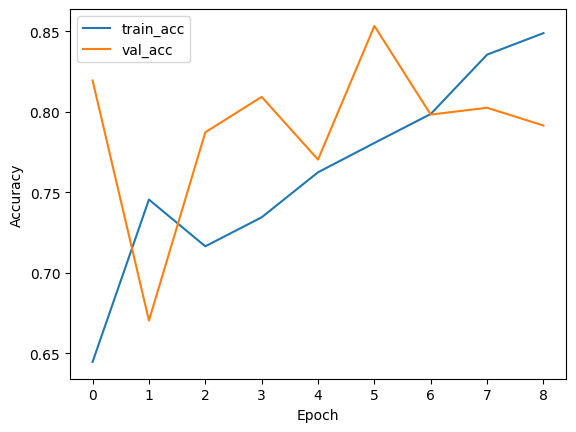

In [7]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
val_preds = model.predict(val_gen) > 0.5
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(val_df['binary_label'], val_preds.astype(int)))
print(confusion_matrix(val_df['binary_label'], val_preds.astype(int)))


37/37 [==============================] - 2s 46ms/step
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       975
           1       0.57      0.65      0.61       205

    accuracy                           0.85      1180
   macro avg       0.75      0.77      0.76      1180
weighted avg       0.86      0.85      0.86      1180

[[873 102]
 [ 71 134]]


In [10]:
model = tf.keras.models.load_model('burn_triage_cnn.h5')     # or




In [11]:
# Try a lower threshold to boost recall for class 1
for thresh in [0.5, 0.4, 0.3]:
    print(f"\n--- Results at threshold {thresh} ---")
    val_preds_thresh = (val_preds > thresh).astype(int).flatten()
    print(classification_report(val_df['binary_label'], val_preds_thresh))
    print(confusion_matrix(val_df['binary_label'], val_preds_thresh))


--- Results at threshold 0.5 ---
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       975
           1       0.57      0.65      0.61       205

    accuracy                           0.85      1180
   macro avg       0.75      0.77      0.76      1180
weighted avg       0.86      0.85      0.86      1180

[[873 102]
 [ 71 134]]

--- Results at threshold 0.4 ---
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       975
           1       0.57      0.65      0.61       205

    accuracy                           0.85      1180
   macro avg       0.75      0.77      0.76      1180
weighted avg       0.86      0.85      0.86      1180

[[873 102]
 [ 71 134]]

--- Results at threshold 0.3 ---
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       975
           1       0.57      0.65      0.61       205

    accuracy                      